## Neural Networks Basics 🧠
*A Beginner's Guide to Understanding Artificial Intelligence*
Created for my son to help him understand AI concepts in a simple way :)

In this notebook, we'll explore:

1. **🔢 Tensors** - The building blocks of AI
2. **🖼️ Image Processing** - How computers "see" and understand pictures
3. **⚡ GPU Power** - Why graphics cards make AI so fast
4. **📊 Loss Functions** - How AI learns from its mistakes
5. **🧠 Neural Networks** - Building your first AI brain

In this notebook, we'll use `Pytorch`, a popular library for building neural networks. We'll also use `torchvision`, which has tools for working with images. The easiest way to run this notebook is on [Google Colab](https://colab.research.google.com/), which provides free access to GPUs (graphics processing units) that make training neural networks much faster. To run this notebook on Google Colab, click on "File" and then "Upload notebook". Make sure you select a **T4 GPU** by clicking on "Runtime" → "Change runtime type" → "Hardware accelerator" → "T4 GPU". This will make everything run much faster!

In [5]:
import torch
import math
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

print("Using torch", torch.__version__)


Using torch 2.8.0+cu126


/tmp/ipython-input-177784815.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [6]:
# Set seeds to make the code reproducible
torch.manual_seed(42)

# GPUs have their own sets
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Tensors
A Tensor is a data structure for holding numbers, kind of like a flexible container. You can think of it as a **multi-dimensional array**:

- A single number is a 0-D tensor.
- A list of numbers (vector) is a 1-D tensor.
- A grid (matrix) is a 2-D tensor.
- Beyond that, tensors can go into 3-D, 4-D, and higher dimensions.

We can use tensors to store data like images (pixel values), text (word embeddings), or even audio signals.

Their real power comes from being able to run operations on them super fast using GPUs which is how models are training.

In [ ]:
# 1D Tensor (Vector) - list of numbers
vector = torch.tensor([1, 2, 3, 4])
print("Vector:", vector)

Vector: tensor([1, 2, 3, 4])


In [ ]:
# 2D Tensor (Matrix) - grid of numbers
matrix = torch.tensor([[1, 2, 3],
                       [4, 5, 6]])
print("\nMatrix:\n", matrix)


Matrix:
 tensor([[1, 2, 3],
        [4, 5, 6]])


In [ ]:
# 3D Tensor - e.g. stack of matrices
tensor3d = torch.tensor([[[1, 2, 3],
                          [4, 5, 6]],

                         [[7, 8, 9],
                          [10, 11, 12]]])
print("\n3D Tensor:\n", tensor3d)


3D Tensor:
 tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])


## Why Tensors

Let us do a speed comparison between CPU and GPU. When training machine learning models, we multiply very large tensors.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
import torch, time

# Make a big tensor on CPU
x = torch.randn(5000, 5000, dtype=torch.float32)

# --- CPU timing ---
t0 = time.perf_counter()
_ = torch.matmul(x, x)
t1 = time.perf_counter()
print(f"CPU time: {t1 - t0:.4f} s")

# --- GPU timing (if available) ---
if torch.cuda.is_available():
    x_gpu = x.to("cuda") # move the tensor to GPU (VRAM)

    # Burn-in (first call to warm up GPU)
    _ = torch.matmul(x_gpu, x_gpu)
    torch.cuda.synchronize()

    # Timed GPU op
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    _ = torch.matmul(x_gpu, x_gpu)
    end.record()
    torch.cuda.synchronize() # wait for everything to start running
    print(f"GPU time: {start.elapsed_time(end) / 1000:.4f} s")
else:
    print("No GPU detected.")

CPU time: 1.9596 s
GPU time: 0.0708 s


# Loss Functions

A loss functions (aka cost or objective) turns the model's predictions into a single number that tells us how bad the prediction was. During training, the model tries to minimize this number (with techniques like gradient descent) to make predictions more accurate.

Pytorch comes with many built-in loss functions (`torch.nn.*Loss`). In practice, the most commonly used loss functions depend on the type of the model: regression models (output continuous values) often use Mean Squared Error Loss (`nn.MSELoss`), while classification models (predict discrete classes) typically use Cross Entropy Loss (`nn.CrossEntropyLoss`).

| ML Task | Loss Function | How It Works | When to Use |
|---------|---------------|--------------|-------------|
| **Regression** | *Mean-Squared Error* (MSE / L2) | Squares the errors → punishes large mistakes heavily | Predicting house prices, temperatures, stock values |
| | *Mean-Absolute Error* (MAE / L1) | Takes absolute difference → treats all errors equally | When you want to be less sensitive to outliers |
| | | | |
| **Binary Classification** | *Binary Cross-Entropy* (BCE) | Measures how far predictions are from true probabilities | Email spam detection, medical diagnosis (yes/no) |
| | | Punishes confident wrong predictions severely | Image classification (cat vs dog) |
| | | | |
| **Multi-class Classification** | *Cross-Entropy* | Same idea as BCE but for multiple classes | Fashion items (10 categories), digit recognition |
| | | Encourages the model to be confident about correct class | Sentiment analysis (positive/negative/neutral) |

### Loss Functions: Regression

For regression algorithms (continous valued output e.g. predicted house prices), we use MAE, MSE to optimize loss.

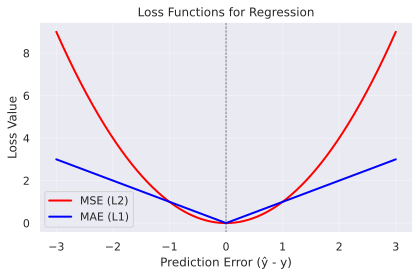

In [2]:
import torch.nn as nn

# Create a range of prediction errors from -3 to +3
errors = torch.linspace(-3, 3, steps=400)

# Calculate different loss functions
mse_loss = errors ** 2  # Mean Squared Error (L2)
mae_loss = torch.abs(errors)  # Mean Absolute Error (L1)

# Create the plot
plt.figure(figsize=(6, 4), dpi=120)
plt.plot(errors.numpy(), mse_loss.numpy(), label='MSE (L2)', lw=2, color='red')
plt.plot(errors.numpy(), mae_loss.numpy(), label='MAE (L1)', lw=2, color='blue')
plt.axvline(0, color='black', lw=0.7, linestyle='--', alpha=0.7)
plt.title('Loss Functions for Regression')
plt.xlabel('Prediction Error (ŷ - y)')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Loss Function: Classification

For classification algorithms (discrete output e.g. spam or no-spam, we use cross-entropy for optimizing loss.

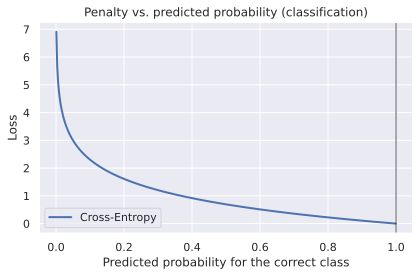

In [ ]:
# Probabilities assigned to the true class (from 0.01 to 0.99)
p_true = torch.linspace(0.001, 0.999, steps=400)

# Cross-Entropy loss = -log(p_true)
cross_entropy = -torch.log(p_true)

plt.figure(figsize=(6, 4), dpi=120)
plt.plot(p_true.detach().numpy(), cross_entropy.detach().numpy(), label="Cross-Entropy", lw=2)
plt.axvline(1.0, color="k", lw=.7)
plt.title("Penalty vs. predicted probability (classification)")
plt.xlabel("Predicted probability for the correct class")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()



## Simple Neural Network

In [7]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Load the Fashion-MNIST dataset (28x28 grayscale)

### Exploring Fashion-MNIST
Before we dive further, let's explore the Fashion-MNIST dataset.


Raw image type: <class 'PIL.Image.Image'>


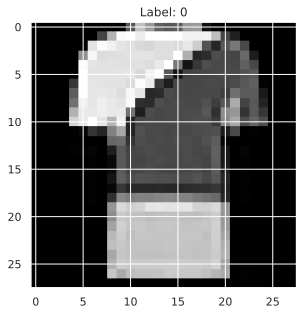



Tensor shape: torch.Size([1, 28, 28])
Tensor values for row: 5 :
 5 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0118, 1.0000, 0.8941, 0.8941, 0.8941,
        0.8941, 0.9020, 0.8471, 0.9490, 1.0000, 0.3373, 0.0706, 0.2627, 0.2745,
        0.2745, 0.2824, 0.2941, 0.2902, 0.3255, 0.3529, 0.0000, 0.0000, 0.0000,
        0.0000])

Normalized tensor shape: torch.Size([1, 28, 28])
Normalized values for row 5:
 tensor([-0.8102, -0.8102, -0.8102, -0.8102, -0.7769,  2.0227,  1.7227,  1.7227,
         1.7227,  1.7227,  1.7449,  1.5894,  1.8782,  2.0227,  0.1452, -0.6102,
        -0.0659, -0.0326, -0.0326, -0.0103,  0.0230,  0.0119,  0.1119,  0.1896,
        -0.8102, -0.8102, -0.8102, -0.8102])


In [ ]:
# Load the dataset
dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=None)

# Pick a random image and let's review it
img, label = dataset[504]
print("Raw image type:", type(img))  # Type=PIL (raw image format)

import matplotlib.pyplot as plt

# Convert the image to Tensor
img_tensor = transforms.ToTensor()(img)

# Display the image.
plt.imshow(img_tensor.squeeze(), cmap="gray")
plt.title(f"Label: {label}")
plt.show()

random_row = 5 # Random row to display

# Display pixel values for the row. Notice that each pixel is between 0 -> 1
# In Fashion-MNIST, 0 = black (ink) and 1 = white (background).
print("\n\nTensor shape:", img_tensor.shape)
print(f"Tensor values for row: {random_row} :\n", random_row, img_tensor[0,random_row,:])

# Next, we normalize the tensor to centralize between -1 -> 1. This helps the
# NN perform better and avoid exploding or vanishing gradients (more on it later).

normalize = transforms.Normalize(mean=(0.2860,), std=(0.3530,))
img_norm = normalize(img_tensor)
print("\nNormalized tensor shape:", img_norm.shape)
print(f"Normalized values for row {random_row}:\n", img_norm[0,random_row,:])


### Prepare the dataset for processing
Now that we are familiar with the dataset and normalization, let's load it for processing.

In [8]:
# Create a transform to convert images to tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.2860,), std=(0.3530,))
])

train_full = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

# Train/val split
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.43MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.0MB/s]


### Building a Simple Neural Network

Our network architecture is:

**784 → 256 → 128 → 10**

- **784 inputs** = 28x28 pixels will be flattened into a single vector (flattening will happen in the `forward` method)
- **2 hidden layers** = 256 and 128 neurons with ReLU activations  
- **10 outputs** = one for each Fashion-MNIST class (0-9)  
- **Dropout** (20%) between layers to reduce overfitting

### How the data flows through the network

Suppose our batch size is 64. Before entering the network, each image is a 28x28 grayscale grid:

```
Image #1: [1 x 28 x 28 grid]
Image #2: [1 x 28 x 28 grid]
...
Image #64: [1 x 28 x 28 grid]
```

Together, the batch has shape: torch.Size([64, 1, 28, 28])

- `64` = batch size  
- `1` = number of channels (grayscale)  
- `28 x 28` = image dimensions  

Since fully connected layers expect **flat vectors**, we reshape each image into a row of 784 values:

```
Image #1: [784 values]
Image #2: [784 values]
...
Image #64: [784 values]
```

Now the batch has shape: torch.Size([64, 784])

This matches the input size of our first linear layer (`fc1`).

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256) # 1st layer: 784 neurons -> 256 neurons
        self.fc2 = nn.Linear(256, 128) # 2nd layer: 256 neurons -> 128
        self.fc3 = nn.Linear(128, 10) # 3rd layer: 128 neurons -> 10 neurons
        self.dropout = nn.Dropout(p=0.2) # Randomly reset (output 0) 20% of neurons to avoid overfitting (network doesn't over rely on a single neuron)
    def forward(self, x):
        # This is called during training. X is a tensor containing batch_size
        # images. If our batch_size=64, X would have 64 images of 28x28 pixels
        # print(x.shape) # This will output: torch.Size([64, 1, 28, 28]). 1 means
                       # channel and since it is a gray-scale image, we only have single channel

        # The next line flattens the images tensor by dropping channel (1) and
        # making each image a flattened vector of 784 pixels.
        x = x.view(x.size(0), -1)
        # print(x.shape) # torch.Size([64, 784])

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x) # raw, unnormalized scores for each of the 10 classes e.g. [-1.2, 0.3, 2.1, -0.7, ... , 0.5]

        return logits

model = MLP().to(device)

- ### Loss Function

At the end of our network, we get logits. 10 raw scores (logits) for each image. The highest score indicates the most likely class.

Strong gradient signal: wrong but confident predictions get penalized heavily.

Cross-entropy loss is designed for **classification**. It:
- rewards confident correct predictions.
- punishes confident wrong predictions.

Suppose the true label is "Sneaker" (class 7):

Logits from the network: [1.2, -0.3, 0.5, ..., 2.0]

After softmax: probabilities like [0.05, 0.01, 0.02, ..., 0.70]

Probability of true class (7) = 0.70

Loss = -log(0.70) ≈ 0.356

👉 If the model had said only 0.01 for class 7, loss would be -log(0.01) ≈ 4.6 (much worse).

#### Why not MSE or MAE?

Those are great for regression, but bad fits for classification.

- MAE (Mean Absolute Error): Uses absolute differences. The gradient is constant — doesn't punish "very wrong" predictions more than "slightly wrong."

- MAPE (Mean Absolute Percentage Error): Designed for numeric forecasting (e.g. sales, time series). Doesn't make sense for categorical class probabilities.

#### Cross-Entropy is best for classification

- Directly measures how well predicted probability distribution matches the true label.
- Strong gradient signal: wrong but confident predictions get penalized heavily.
- Naturally works with logits → softmax → one-hot truth.

That's why nearly every classification network in deep learning uses cross-entropy.

In [11]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

def accuracy(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            optimizer.step()
        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

### Run the Training

We split the dataset into 3 separate classes: Train, validate and test. We don't want to use the same exact data to both train and evaluate, because then our model could just memorize answers without really learning to generalize.

#### Training Set (train)

**Purpose: Teach the model.**

The model actually “sees” these examples and updates weights using gradient descent.

Example: 55,000 Fashion-MNIST images.

*Analogy:
📝 Think of this as practice questions you study from.*

#### Validation Set (val)

**Purpose: Tune and monitor.**

The model does not update weights here.

You run predictions on it after each epoch to see if the model is really learning or just memorizing.

Used for decisions like:

When to stop training (early stopping).

Which hyperparameters work best (learning rate, number of layers, etc.).

Which checkpoint of the model is “best so far.”

*Analogy:
📖 These are your mock exams while studying. You don't “learn” from them, but they tell you if your studying is working.*


#### Test Set (test)

**Purpose: Final unbiased evaluation.**

Used only once at the very end after you’ve chosen your best model.

This gives you a fair estimate of how well the model would perform on new, unseen data.

*Analogy:
🎓 This is the final exam. You don’t touch it while studying. You only take it once, to see your true performance.*

#### Putting it together

Example with Fashion-MNIST (70,000 images total):

- Train: 55,000 images → used to update weights.
- Validation: 5,000 images → used to track progress and save “best model.”
- Test: 10,000 images → used only at the end to report accuracy.

### Qs: Why not just train + test?

If you skip validation you might overfit to the training data.

You might pick hyperparameters that look good on training, but fail on new data.

Validation is the “safety net” that keeps you honest during development.

In [ ]:
best_val = 0.0
for epoch in range(1, 15):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss,   val_acc   = run_epoch(val_loader,   train=False)
    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), 'best_mlp_fashionmnist.pt')
    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} acc {train_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")

# Final test
model.load_state_dict(torch.load('best_mlp_fashionmnist.pt', map_location=device))
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test  | loss {test_loss:.4f} acc {test_acc:.4f}")

Epoch 01 | train loss 0.3910 acc 0.8576 | val loss 0.3636 acc 0.8680
Epoch 02 | train loss 0.3561 acc 0.8693 | val loss 0.3330 acc 0.8766
Epoch 03 | train loss 0.3315 acc 0.8782 | val loss 0.3259 acc 0.8854
Epoch 04 | train loss 0.3201 acc 0.8825 | val loss 0.3248 acc 0.8836
Epoch 05 | train loss 0.3036 acc 0.8863 | val loss 0.3029 acc 0.8854
Epoch 06 | train loss 0.2928 acc 0.8915 | val loss 0.3222 acc 0.8840
Epoch 07 | train loss 0.2832 acc 0.8943 | val loss 0.3118 acc 0.8878
Epoch 08 | train loss 0.2714 acc 0.8992 | val loss 0.3019 acc 0.8926
Epoch 09 | train loss 0.2660 acc 0.9002 | val loss 0.3066 acc 0.8908
Epoch 10 | train loss 0.2575 acc 0.9037 | val loss 0.3213 acc 0.8856
Epoch 11 | train loss 0.2526 acc 0.9046 | val loss 0.3051 acc 0.8914
Epoch 12 | train loss 0.2476 acc 0.9067 | val loss 0.3017 acc 0.8924
Epoch 13 | train loss 0.2403 acc 0.9093 | val loss 0.3040 acc 0.8888
Epoch 14 | train loss 0.2368 acc 0.9109 | val loss 0.2991 acc 0.8936
Test  | loss 0.3337 acc 0.8832


### Load and Test the Model

Now that we have generate the model, let's load it and test it against a random image.



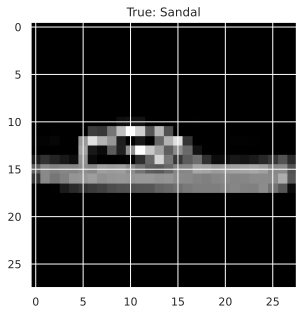

True label - 5:Sandal | Predicted - 5:Sandal


In [ ]:
import random

# Map integer labels to class names
classes = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

model = MLP().to(device)
model.load_state_dict(torch.load("best_mlp_fashionmnist.pt", map_location=device))
model.eval()

# Pick a random test sample
idx = random.randint(0, len(test_ds)-1)
img, label = test_ds[idx]

# Show the image
plt.imshow(img.squeeze().numpy(), cmap="gray")
plt.title(f"True: {classes[label]}")
plt.show()

# Prepare input (add batch dimension)
x = img.unsqueeze(0).to(device)

# Run through model
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()

print(f"True label - {label}:{classes[label]} | Predicted - {label}:{classes[pred]}")


## Conventional Neural Network (Advanced)

Now let's use CNNs on Fashion-MNIST.

**What this CNN does (and how it differs from the MLP)?**

Convolutions look at small 3x3 neighborhoods, not all 784 pixels at once. The same 3x3 filter (kernel) slides across the image → far fewer parameters than a fully connected layer and a built-in bias toward edges/parts.

In [3]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # (B,1,28,28)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # → (B,16,28,28)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # → (B,32,28,28)
        self.pool  = nn.MaxPool2d(2)                              # halves H,W
        self.dropout = nn.Dropout(p=0.25)
        # After two pools: 28→14→7, channels=32 ⇒ 32*7*7 features
        self.fc1 = nn.Linear(32*7*7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # x: (B,1,28,28)
        x = F.relu(self.conv1(x))          # (B,16,28,28)
        x = self.pool(x)                   # (B,16,14,14)
        x = F.relu(self.conv2(x))          # (B,32,14,14)
        x = self.pool(x)                   # (B,32,7,7)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)          # (B, 32*7*7)
        x = F.relu(self.fc1(x))            # (B,64)
        x = self.dropout(x)
        logits = self.fc2(x)               # (B,10)
        return logits

In [9]:
model = SmallCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
best_val = 0.0
for epoch in range(1, 15):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss,   val_acc   = run_epoch(val_loader,   train=False)

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), 'best_cnn_fashionmnist.pt')

    print(f"Epoch {epoch:02d} | train loss {train_loss:.4f} acc {train_acc:.4f} "
          f"| val loss {val_loss:.4f} acc {val_acc:.4f}")

Epoch 01 | train loss 0.5619 acc 0.7972 | val loss 0.3761 acc 0.8596
Epoch 02 | train loss 0.3806 acc 0.8623 | val loss 0.3097 acc 0.8780
Epoch 03 | train loss 0.3380 acc 0.8777 | val loss 0.2717 acc 0.8970
Epoch 04 | train loss 0.3114 acc 0.8873 | val loss 0.2678 acc 0.8982
Epoch 05 | train loss 0.2905 acc 0.8943 | val loss 0.2551 acc 0.9076
Epoch 06 | train loss 0.2747 acc 0.8989 | val loss 0.2370 acc 0.9100
Epoch 07 | train loss 0.2617 acc 0.9040 | val loss 0.2391 acc 0.9098
Epoch 08 | train loss 0.2478 acc 0.9075 | val loss 0.2375 acc 0.9066
Epoch 09 | train loss 0.2411 acc 0.9102 | val loss 0.2328 acc 0.9094
Epoch 10 | train loss 0.2324 acc 0.9148 | val loss 0.2218 acc 0.9144
Epoch 11 | train loss 0.2271 acc 0.9158 | val loss 0.2204 acc 0.9164
Epoch 12 | train loss 0.2175 acc 0.9193 | val loss 0.2155 acc 0.9180
Epoch 13 | train loss 0.2128 acc 0.9199 | val loss 0.2148 acc 0.9178
Epoch 14 | train loss 0.2038 acc 0.9237 | val loss 0.2214 acc 0.9188


In [13]:
model.load_state_dict(torch.load('best_cnn_fashionmnist.pt', map_location=device))
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test  | loss {test_loss:.4f} acc {test_acc:.4f}")

Test  | loss 0.2484 acc 0.9138


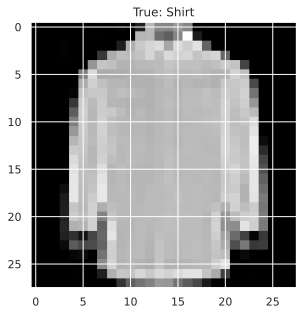

True: Shirt | Pred: Shirt


In [19]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

classes = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
           "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

idx = random.randint(0, len(test_ds)-1)
img, label = test_ds[idx]

plt.imshow(img.squeeze().numpy(), cmap="gray")
plt.title(f"True: {classes[label]}")
plt.show()

x = img.unsqueeze(0).to(device)   # (1,1,28,28)
model.eval()
with torch.no_grad():
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()

print(f"True: {classes[label]} | Pred: {classes[pred]}")
